# ETL Galaxy Zoo 2 - Model training - FC

by BRAUX Owen and CAMBIER Elliot in 2026

## Imports 

In [6]:
import os
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

## Configuration

In [7]:
PROJECT_NAME = "Galaxy_model_FC"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
IMG_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SEED = 42

# - Kaggle : "../input/..." to complete !
# - Local : "dataset_images"
DATA_DIR = "/kaggle/input/datasets/owenbraux/galaxy-dataset-brauxo" 

def set_seed(seed=42):
    """Fixe les graines pour la reproductibilité totale."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

## Data loader

In [8]:
def get_data_loaders(data_dir, batch_size, img_size):
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        # Normalisation ImageNet for transfer learning !!!
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Validation (no augment)
    val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        full_dataset = datasets.ImageFolder(root=data_dir)
    except FileNotFoundError:
        print(f"ERREUR : Le dossier '{data_dir}' est introuvable.")
        return None, None, None

    # Split Train/Val (80% / 20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    # Split will always be the same
    train_subset, val_subset = random_split(
        full_dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(SEED)
    )
    

    train_subset.dataset.transform = train_transforms 
    
    train_ds = datasets.ImageFolder(root=data_dir, transform=train_transforms)
    val_ds = datasets.ImageFolder(root=data_dir, transform=val_transforms)
    
    # Takes indices of the last split randomly
    train_indices = train_subset.indices
    val_indices = val_subset.indices
    
    train_data = torch.utils.data.Subset(train_ds, train_indices)
    val_data = torch.utils.data.Subset(val_ds, val_indices)

    # Loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, full_dataset.classes

train_loader, val_loader, class_names = get_data_loaders(DATA_DIR, BATCH_SIZE, IMG_SIZE)

print(f"Classes détectées : {class_names}")
print(f"Train size : {len(train_loader.dataset)} images")
print(f"Val size   : {len(val_loader.dataset)} images")

Classes détectées : ['0_Elliptique_Ronde', '1_Elliptique_Allongee', '2_Lenticulaire', '3_Spirale_Serree', '4_Spirale_Moyenne', '5_Spirale_Lache', '6_Barree_Serree', '7_Barree_Moyenne', '8_Barree_Lache', '9_Merger_Irreguliere']
Train size : 15996 images
Val size   : 3999 images


## Model

In [9]:
class GalaxyFC(nn.Module):
    def __init__(self, num_classes):
        super(GalaxyFC, self).__init__()
        self.flatten = nn.Flatten()
        # Entrée : 64*64*3 = 12,288 pixels
        self.layers = nn.Sequential(
            nn.Linear(64 * 64 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)
    
model = GalaxyFC(num_classes=len(class_names)).to(DEVICE)

## Training

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model.pth')
                    print(f"-> Nouveau record")

        print()

    time_elapsed = time.time() - since
    print(f'Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure Val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10)

Epoch 1/10
----------
train Loss: 2.4791 Acc: 0.0978
val Loss: 2.3033 Acc: 0.0998
-> Nouveau record

Epoch 2/10
----------
train Loss: 2.3070 Acc: 0.1005
val Loss: 2.3032 Acc: 0.0998

Epoch 3/10
----------
train Loss: 2.3046 Acc: 0.0991
val Loss: 2.3030 Acc: 0.0915

Epoch 4/10
----------
train Loss: 2.3033 Acc: 0.1005
val Loss: 2.3029 Acc: 0.0915

Epoch 5/10
----------
train Loss: 2.3035 Acc: 0.1031
val Loss: 2.3030 Acc: 0.0915

Epoch 6/10
----------
train Loss: 2.3056 Acc: 0.1032
val Loss: 2.3030 Acc: 0.0915

Epoch 7/10
----------
train Loss: 2.3031 Acc: 0.1000
val Loss: 2.3030 Acc: 0.0915

Epoch 8/10
----------
train Loss: 2.3027 Acc: 0.1014
val Loss: 2.3030 Acc: 0.0915

Epoch 9/10
----------
train Loss: 2.3028 Acc: 0.0966
val Loss: 2.3029 Acc: 0.0915

Epoch 10/10
----------
train Loss: 2.3027 Acc: 0.1019
val Loss: 2.3029 Acc: 0.0915

Entraînement terminé en 2m 58s
Meilleure Val Acc: 0.0998


## Analysis (plotting)

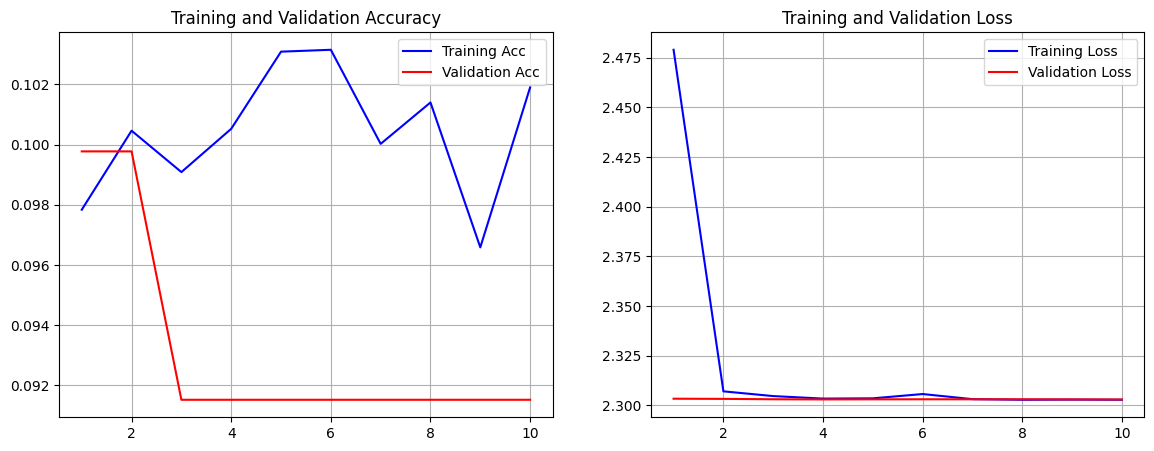

Calcul de la matrice de confusion...


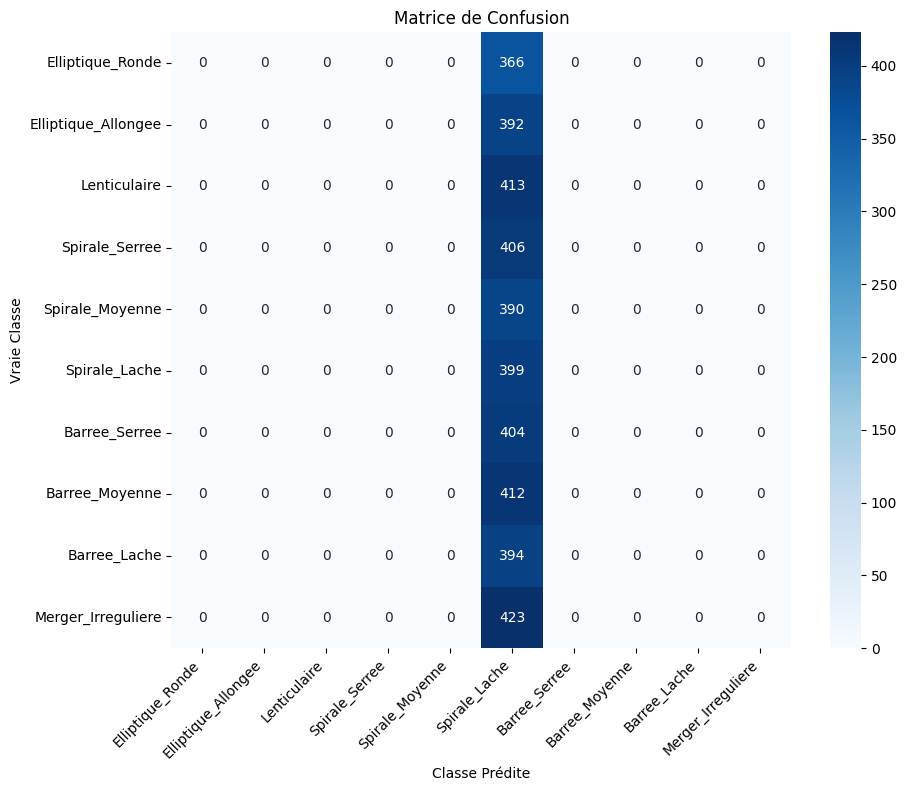

                     precision    recall  f1-score   support

   Elliptique_Ronde       0.00      0.00      0.00       366
Elliptique_Allongee       0.00      0.00      0.00       392
       Lenticulaire       0.00      0.00      0.00       413
     Spirale_Serree       0.00      0.00      0.00       406
    Spirale_Moyenne       0.00      0.00      0.00       390
      Spirale_Lache       0.10      1.00      0.18       399
      Barree_Serree       0.00      0.00      0.00       404
     Barree_Moyenne       0.00      0.00      0.00       412
       Barree_Lache       0.00      0.00      0.00       394
 Merger_Irreguliere       0.00      0.00      0.00       423

           accuracy                           0.10      3999
          macro avg       0.01      0.10      0.02      3999
       weighted avg       0.01      0.10      0.02      3999



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
def plot_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, loader, class_names):
    y_pred = []
    y_true = []
    model.eval()
    
    print("Calcul de la matrice de confusion...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    clean_names = [c.split('_', 1)[1] if '_' in c else c for c in class_names]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=clean_names, yticklabels=clean_names)
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.title('Matrice de Confusion')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    print(classification_report(y_true, y_pred, target_names=clean_names))

plot_history(history)
plot_confusion_matrix(model, val_loader, class_names)

## Visualisation :

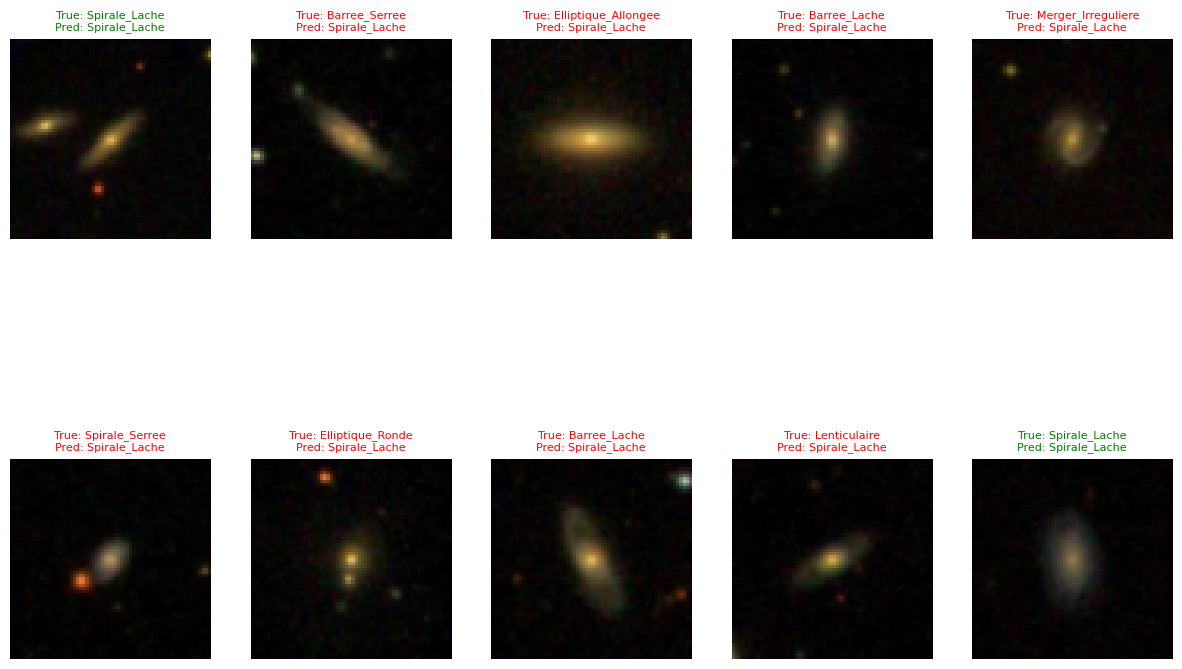

In [12]:
def visualize_predictions(model, loader, num_images=10):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(2, 5, images_so_far)
                ax.axis('off')
                
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)
                true_label = class_names[labels[j]].split('_', 1)[1]
                pred_label = class_names[preds[j]].split('_', 1)[1]
                
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=8)
                
                if images_so_far == num_images:
                    return

visualize_predictions(model, val_loader, num_images=10)